# 02_feature_engineering_v2.1

Stable feature-engineering notebook with TSFresh enabled by default and memory optimizations for 16GB RAM.

Pipeline: `raw data -> oscillator -> signal detector -> semantically rich composites -> TSFresh -> feature selection -> model`.

Defaults: processes `net_gex` and `gamma_flip_strike_perc`. If you don't have `combined_files.zip`, it will generate synthetic data.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
os.environ["NUMBA_DISABLE_CUDA"] = "1"
warnings.filterwarnings("ignore", category=UserWarning, module="tsfresh")

ROOT = Path('.').resolve()
DATA_DIR = ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
PROCESSED_DIR = DATA_DIR / 'processed'
MODELS_DIR = ROOT / 'models'
for p in [INTERIM_DIR, PROCESSED_DIR, MODELS_DIR]: p.mkdir(parents=True, exist_ok=True)
print('Paths prepared:')
print('INTERIM:', INTERIM_DIR)
print('PROCESSED:', PROCESSED_DIR)
print('MODELS:', MODELS_DIR)


Paths prepared:
INTERIM: E:\NuFinTech\notebooks\data\interim
PROCESSED: E:\NuFinTech\notebooks\data\processed
MODELS: E:\NuFinTech\notebooks\models


## 1) Data load / Synthetic generator

If you have real data in `data/raw/combined_files.zip`, you can answer `n` to the prompt and provide the path. Otherwise the notebook will generate a synthetic dataset and save it to `data/processed/synthetic_trades.parquet`. The synthetic dataset is small and designed to exercise the pipeline.

In [2]:
import zipfile, io

def generate_synthetic(n=3000, seed=42):
    rng = np.random.default_rng(seed)
    symbols = ['AAPL','MSFT','GOOG','TSLA']
    rows = []
    base = pd.Timestamp('2024-01-01')
    for i in range(n):
        sym = str(rng.choice(symbols))
        entry = base + pd.Timedelta(days=int(i/len(symbols)))
        exitd = entry + pd.Timedelta(hours=int(rng.integers(1,48)))
        net_gex = float(rng.normal(0,1) * (1 + rng.random()*5))
        gamma_flip = float(rng.normal(0,0.6))
        pnl = float(rng.normal(0,1))
        rows.append({
            'trade_id': int(i),
            'symbol': sym,
            'entry_date': entry.isoformat(),
            'exit_date': exitd.isoformat(),
            'entry_cost': 100.0 + float(rng.normal()),
            'exit_cost': 100.0 + float(rng.normal()),
            'pnl': pnl,
            'net_gex': net_gex,
            'z20_net_gex': net_gex/ (abs(net_gex)+1e-6),
            'neutral_gex': bool(rng.choice([0,1], p=[0.2,0.8])),
            'gamma_flip_strike_perc': gamma_flip,
        })
    df = pd.DataFrame(rows)
    df['label'] = (df['pnl'] > 0).astype(int)
    return df

use_synth = input('Use synthetic data? (y/n) [default y]: ') or 'y'
if use_synth.lower().startswith('y'):
    synth_path = PROCESSED_DIR / 'synthetic_trades.parquet'
    if not synth_path.exists():
        df = generate_synthetic(3000)
        df.to_parquet(synth_path, index=False)
        print('Synthetic data created at', synth_path)
    else:
        df = pd.read_parquet(synth_path)
        print('Loaded existing synthetic dataset', synth_path)
else:
    zip_path = input('Path to combined_files.zip (relative or full): ').strip()
    if not zip_path:
        raise ValueError('No path provided')
    zp = zipfile.ZipFile(zip_path)
    df = None
    for n in zp.namelist():
        if n.lower().endswith('.parquet'):
            df = pd.read_parquet(io.BytesIO(zp.read(n)))
            break
        if n.lower().endswith('.csv'):
            df = pd.read_csv(io.BytesIO(zp.read(n)))
            break
    if df is None:
        raise ValueError('No csv/parquet found in zip')

print('Loaded rows:', len(df))
df.head()


Use synthetic data? (y/n) [default y]:  


Loaded existing synthetic dataset E:\NuFinTech\notebooks\data\processed\synthetic_trades.parquet
Loaded rows: 2000


,trade_id,symbol,entry_date,exit_date,entry_cost,exit_cost,pnl,net_gex,gamma_flip_strike_perc,label
0,0,AAPL,2024-01-01,2024-01-01 09:00:00,98.048965,98.697820,0.127840,-5.504625,0.470282,1
1,1,GOOG,2024-01-01,2024-01-01 09:00:00,100.777792,100.066031,1.127241,-0.054636,0.439699,1
2,2,GOOG,2024-01-01,2024-01-01 05:00:00,100.878450,99.950074,-0.184862,-3.242045,-0.479441,0
3,3,GOOG,2024-01-01,2024-01-01 04:00:00,99.647866,100.532309,0.365444,6.681929,-0.214164,1
4,4,GOOG,2024-01-02,2024-01-02 02:00:00,99.487757,99.186227,0.615979,2.035117,-0.203208,1


## 2) Choose columns to process

Default: `net_gex, gamma_flip_strike_perc`. You may edit the input. The notebook will process each column independently and then merge composites. (Processing both is the recommended flow.)

In [3]:
col_input = input('Enter columns (comma-separated) [default: net_gex, gamma_flip_strike_perc]: ') or 'net_gex, gamma_flip_strike_perc'
cols = [c.strip() for c in col_input.split(',')]
print('Processing columns:', cols)


Enter columns (comma-separated) [default: net_gex, gamma_flip_strike_perc]:  


Processing columns: ['net_gex', 'gamma_flip_strike_perc']


## 3) Oscillator builder (robust, vectorized)

Creates `_z`, `_osc`, `_mom_tanh`, and `_rsi` series per column. Rolling windows are non-centered and causal.

In [4]:
ROLL_Z = 100
RSI_N = 14
MOM_N = 5

def build_oscillator(df, col, roll_z=ROLL_Z, rsi_n=RSI_N, mom_n=MOM_N):
    out = df.copy()
    s = out[col].astype(float)
    out[f'{col}_mean'] = s.rolling(roll_z, min_periods=10).mean()
    out[f'{col}_std'] = s.rolling(roll_z, min_periods=10).std().replace(0, 1e-6)
    out[f'{col}_z'] = (s - out[f'{col}_mean']) / out[f'{col}_std']
    out[f'{col}_osc'] = np.tanh(out[f'{col}_z'])
    # momentum and tanh scaling
    out[f'{col}_mom'] = (s - s.shift(mom_n)) / (s.shift(mom_n).abs() + 1e-9)
    out[f'{col}_mom_tanh'] = np.tanh(out[f'{col}_mom'])
    # rsi-like on raw series
    delta = s.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    out[f'{col}_rs'] = up.rolling(rsi_n, min_periods=3).mean() / (down.rolling(rsi_n, min_periods=3).mean() + 1e-9)
    out[f'{col}_rsi'] = 100 - (100 / (1 + out[f'{col}_rs']))
    return out

# Apply per column and save oscillator files
for col in cols:
    if col not in df.columns:
        print(f'WARNING: column {col} not in dataframe — skipping')
        continue
    osc = build_oscillator(df, col)
    path = INTERIM_DIR / f'{col}_oscillator.parquet'
    osc.to_parquet(path, index=False)
    print('Wrote oscillator:', path)

print('Oscillator step complete')


Wrote oscillator: E:\NuFinTech\notebooks\data\interim\net_gex_oscillator.parquet
Wrote oscillator: E:\NuFinTech\notebooks\data\interim\gamma_flip_strike_perc_oscillator.parquet
Oscillator step complete


## 4) Signal detectors

Attempt to import local `src/signal_detector.py` which may contain advanced detectors. If not present, a robust fallback implementation is used.

In [5]:
import sys
sys.path.append(str(ROOT / 'src'))
use_external = False
try:
    import signal_detector as sd
    use_external = hasattr(sd, 'build_signals')
    print('Imported external signal_detector:', use_external)
except Exception as e:
    print('No external signal_detector available — using fallback.\n', e)

# fallback
def fallback_build_signals(df, col):
    out = df.copy()
    s = out[f'{col}_osc']
    out[f'{col}_cross_up'] = ((s > 0) & (s.shift(1) <= 0)).astype(int)
    out[f'{col}_cross_down'] = ((s < 0) & (s.shift(1) >= 0)).astype(int)
    out[f'{col}_trend_up'] = (s.rolling(5).mean().diff() > 0).astype(int)
    out[f'{col}_trend_down'] = (s.rolling(5).mean().diff() < 0).astype(int)
    out[f'{col}_time_since_cross'] = (~(out[f'{col}_cross_up'] | out[f'{col}_cross_down'])).astype(int).cumsum()
    return out

# run detectors
for col in cols:
    path = INTERIM_DIR / f'{col}_oscillator.parquet'
    if not path.exists():
        print('Oscillator missing for', col); continue
    tmp = pd.read_parquet(path)
    if use_external:
        tmp = sd.build_signals(tmp, col)
    else:
        tmp = fallback_build_signals(tmp, col)
    tmp.to_parquet(INTERIM_DIR / f'{col}_signals.parquet', index=False)
    print('Signals written for', col)

print('Signal detection complete')


No external signal_detector available — using fallback.
 No module named 'signal_detector'
Signals written for net_gex
Signals written for gamma_flip_strike_perc
Signal detection complete


## 5) Build semantically rich composite features

This section builds a set of interpretable composites for each processed column (stability, vol_potential, instability, magnetic_score, cross_persistence), plus several interaction and near-flip features for gamma.

In [6]:
def build_composites(df, col):
    out = df.copy()
    # core composites
    out[f'{col}_stability'] = 1 - out[f'{col}_time_since_cross'] / (1 + out[f'{col}_time_since_cross'])
    out[f'{col}_vol_potential'] = (1 - out[f'{col}_z'].abs()) * out[f'{col}_mom_tanh'].abs()
    out[f'{col}_instability'] = out[f'{col}_mom_tanh'].abs() * (1 - out[f'{col}_z'].abs())
    out[f'{col}_magnetic_score'] = (1 - out[f'{col}_z'].abs()) / (out[f'{col}_time_since_cross'] + 1)
    out[f'{col}_cross_persistence'] = ((out[f'{col}_cross_up'] | out[f'{col}_cross_down']).astype(int)).rolling(5, min_periods=1).sum()

    # near-flip advanced (only meaningful for gamma_flip_strike_perc)
    if col.startswith('gamma') or 'flip' in col:
        out[f'{col}_vol10'] = out[col].rolling(10, min_periods=1).std()
        out[f'{col}_smooth5'] = out[f'{col}_osc'].rolling(5, min_periods=1).mean()
        out[f'{col}_nearflip_approach_speed'] = out[f'{col}_mom'] * (1 - out[f'{col}_z'].abs())
        out[f'{col}_nearflip_flip_inertia'] = out[f'{col}_time_since_cross'] / (out[f'{col}_z'].abs() + 1e-3)
    return out

# create and merge composites
composite_frames = []
for col in cols:
    p = INTERIM_DIR / f'{col}_signals.parquet'
    if not p.exists():
        print('Missing signals for', col); continue
    tmp = pd.read_parquet(p)
    comp = build_composites(tmp, col)
    # collect only composites and trade_id
    comp_cols = [c for c in comp.columns if c.startswith(col) and any(x in c for x in ['stability','vol_potential','instability','magnetic_score','cross_persistence','vol10','smooth5','nearflip'])]
    frame = comp[['trade_id'] + comp_cols]
    composite_frames.append(frame)
    print('Built composites for', col, 'cols:', len(comp_cols))

# merge composites on trade_id
if not composite_frames:
    raise RuntimeError('No composite frames built — check columns')
merged = composite_frames[0]
for other in composite_frames[1:]:
    merged = merged.merge(other, on='trade_id', how='left')

# attach label if available in original df
if 'label' in df.columns:
    merged = merged.merge(df[['trade_id','label']], on='trade_id', how='left')

merged.to_parquet(PROCESSED_DIR / 'merged_composites.parquet', index=False)
print('Wrote merged_composites.parquet with shape', merged.shape)


Built composites for net_gex cols: 5
Built composites for gamma_flip_strike_perc cols: 9
Wrote merged_composites.parquet with shape (2000, 16)


## 6) Data sanitization (remove infs, clip extremes)

Important: avoid infinities / huge values before TSFresh & model training.

In [7]:
merged = pd.read_parquet(PROCESSED_DIR / 'merged_composites.parquet')
print('Before sanitize: cols', merged.shape[1])
merged = merged.replace([np.inf, -np.inf], np.nan).fillna(0)
# clip to reasonable float range
merged = merged.clip(-1e6, 1e6)
merged.to_parquet(PROCESSED_DIR / 'merged_composites_sanitized.parquet', index=False)
print('Sanitized and saved as merged_composites_sanitized.parquet')


Before sanitize: cols 16
Sanitized and saved as merged_composites_sanitized.parquet


## 7) TSFresh extraction (optimized for 16GB RAM)

This will always run (not optional). We construct a compact long-form time series per trade by creating a small window around the oscillator value(s). For real bar-level data, replace this step with your true per-trade bar series. We limit the number of trades sent to TSFresh (MAX_IDS) to avoid exceeding memory.

In [8]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
import numpy as np
import pandas as pd
from pathlib import Path

MAX_IDS = 2000
WINDOW = 20

PROCESSED_DIR = Path("data/processed")   # correct location

san = pd.read_parquet(PROCESSED_DIR / "merged_composites_sanitized.parquet")
ids = san['trade_id'].unique()[:MAX_IDS]

long_rows = []
cols = [c for c in san.columns if c not in ("trade_id", "label")]
for tid in ids:
    row = san.loc[san['trade_id']==tid, cols].iloc[0].astype(float).to_dict()
    for t in range(WINDOW):
        rec = {'id': int(tid), 'time': t}
        rec.update({c: v*(1+0.01*np.random.randn()) for c, v in row.items()})
        long_rows.append(rec)

long_df = pd.DataFrame(long_rows)
print("Long-form shape:", long_df.shape)

fc_params = MinimalFCParameters()
features = extract_features(long_df, column_id='id', column_sort='time', default_fc_parameters=fc_params, n_jobs=4)
features = features.fillna(0)

features.to_parquet(PROCESSED_DIR / "tsfresh_extracted.parquet")
print("Saved:", features.shape)

Long-form shape: (40000, 16)


Feature Extraction: 100%|███████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]

Saved: (2000, 140)


## 8) Merge TSFresh descriptors with composites and run feature selection

In [9]:
tsf = pd.read_parquet(PROCESSED_DIR / 'tsfresh_extracted.parquet')
# align index types
tsf.index = tsf.index.astype(int)
comp = pd.read_parquet(PROCESSED_DIR / 'merged_composites_sanitized.parquet')
comp = comp.set_index('trade_id')
# keep only ids present in tsf (we limited to MAX_IDS)
comp = comp.loc[comp.index.intersection(tsf.index)]

X_full = pd.concat([comp.drop(columns=['label'], errors='ignore'), tsf.reindex(comp.index)], axis=1).fillna(0)
y = comp['label'] if 'label' in comp.columns else pd.Series(0, index=comp.index)
print('Final X_full shape:', X_full.shape)

# sanitize again
X_full = X_full.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)
X_full.to_parquet(PROCESSED_DIR / 'features_full_preselection.parquet')
print('Saved features_full_preselection.parquet')


Final X_full shape: (2000, 154)
Saved features_full_preselection.parquet


## 9) Feature selection (RandomForest importance)

Selected top features: 40
Saved features_train.parquet with shape (2000, 40)


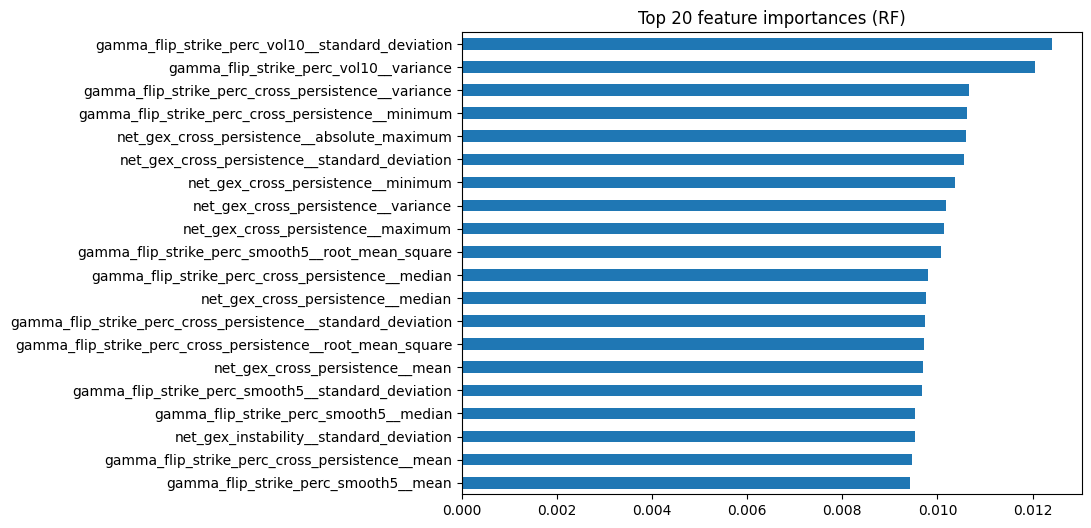

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
rf.fit(X_full, y)
importances = pd.Series(rf.feature_importances_, index=X_full.columns).sort_values(ascending=False)
TOP_K = 40
selected = importances.head(TOP_K).index.tolist()
print('Selected top features:', len(selected))
# save selected
pd.Series(selected).to_csv(MODELS_DIR / 'selected_features_list.csv', index=False)

X_selected = X_full[selected]
X_selected.to_parquet(PROCESSED_DIR / 'features_train.parquet')
print('Saved features_train.parquet with shape', X_selected.shape)

# plot top 20
plt.figure(figsize=(8,6))
importances.head(20).sort_values().plot(kind='barh')
plt.title('Top 20 feature importances (RF)')
plt.show()


## 10) Train Decision Tree and save model + rules

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import joblib

X = X_selected
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=42)
clf.fit(X, y)
probs = clf.predict_proba(X)[:,1]
auc = roc_auc_score(y, probs)
print('Decision Tree AUC (train):', auc)
# save
joblib.dump(clf, MODELS_DIR / 'decision_tree_model.pkl')
print('Saved decision_tree_model.pkl')


Decision Tree AUC (train): 0.6761311295041383
Saved decision_tree_model.pkl


## 11) Rule extraction from tree (human readable)

In [12]:
from sklearn.tree import _tree
import json

def extract_rules(clf, feature_names):
    tree_ = clf.tree_
    rules = []
    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree_.feature[node]]
            thresh = tree_.threshold[node]
            recurse(tree_.children_left[node], path + [f'{name} <= {thresh:.6f}'])
            recurse(tree_.children_right[node], path + [f'{name} > {thresh:.6f}'])
        else:
            value = tree_.value[node][0].tolist()
            pos_rate = value[1] / sum(value) if sum(value) > 0 else 0
            rules.append({'rule': ' and '.join(path), 'samples': int(tree_.n_node_samples[node]), 'positive_rate': float(pos_rate)})
    recurse(0, [])
    return rules

rules = extract_rules(clf, X.columns.tolist())
with open(MODELS_DIR / 'cluster_rules.json', 'w') as f:
    json.dump(rules, f, indent=2)
print('Wrote cluster_rules.json with', len(rules), 'rules')


Wrote cluster_rules.json with 37 rules


## 12) Save performance summary and top rules

In [13]:
import pandas as pd
PERF = {
    'n_samples': int(X.shape[0]),
    'n_features': int(X.shape[1]),
    'auc_train': float(auc)
}
Path('reports/model_performance').mkdir(parents=True, exist_ok=True)
Path('reports/rule_catalog').mkdir(parents=True, exist_ok=True)
pd.Series(PERF).to_frame('value').to_csv(Path('reports/model_performance') / 'performance_summary.csv')
rule_df = pd.DataFrame(rules)
rule_df.sort_values('positive_rate', ascending=False).head(50).to_csv(Path('reports/rule_catalog') / 'top50_rules.csv', index=False)
print('Saved performance_summary and top50_rules')


Saved performance_summary and top50_rules
